# CS4035 - Cyber Data Analytics
## Lab 3 

### Submit on brightspace (zip file with the name Group_xx.zip)
(i) This jupyter file completed with code, plots, figures and report for each question. Additional plots and figures can be created for explanation before the end of each main question. Lab 3 contains 7 main questions, including the bonus. Write the code or explanation below each sub question. For the explantions, include what you would normally include in the report for this lab assignment, for example data pre-processing, hypothesis tested, approach, results, etc.
(ii) A PDF or a Word report for the assignment. Create a report from the plots, figures, tables and the write-up that you provide in this jupyter file. The report will be used as a proof for page limit. 
(iii) The libraries needed to run this file. 

Your peers should be able to use the readme section for instructions and be able to run this file. 

## Group Number :

## Student 1 
### Name :
### ID :

## Student 2
### Name :
### ID :

## 7.Botnet fingerprinting task – 1/2 A4

### 7a. Fingerprinting


#### Implementation

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from jupyterthemes import jtplot
jtplot.style('grade3')

import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.preprocessing import Normalizer, KBinsDiscretizer
from sklearn.decomposition import PCA
from scipy.stats import spearmanr

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


#### Functions for processing

In [2]:
# Function to discretize data
def discretization(df: pd.DataFrame, quantile=10, plot=False, sel=10):
    df = df[~df.Label.str.contains("Background")]

    if sel in [9, 10]:
        Botnet = [
            "147.32.84.165", "147.32.84.191", "147.32.84.192", "147.32.84.193",
            "147.32.84.204", "147.32.84.205", "147.32.84.206", "147.32.84.207",
            "147.32.84.208", "147.32.84.209"
        ]
    elif sel in [11, 12]:
        Botnet = ['147.32.84.165', '147.32.84.191', '147.32.84.192']
    df['Botnet'] = df['SrcAddr'].isin(Botnet)

    protocol_encoder = {'arp': 0, 'udp': 1, 'tcp': 2, 'icmp': 3, 'rtp': 4}
    df["Proto"].replace('arp', protocol_encoder['arp'], inplace=True)
    df["Proto"].replace('udp', protocol_encoder['udp'], inplace=True)
    df["Proto"].replace('tcp', protocol_encoder['tcp'], inplace=True)
    df["Proto"].replace('icmp', protocol_encoder['icmp'], inplace=True)
    df["Proto"].replace('rtp', protocol_encoder['rtp'], inplace=True)

    features = df[['Dur', 'Proto']]
    features_norm = Normalizer().fit_transform(features)
    pca = PCA(n_components=1)
    feature_comb = pca.fit_transform(features_norm,
                                     y=df['Botnet'].values).reshape(-1, 1)

    spearman = []
    for i in range(2, 50):
        KBins = KBinsDiscretizer(n_bins=i,
                                 encode='ordinal',
                                 strategy='quantile')
        feature_disc = KBins.fit_transform(feature_comb)
        spearman.append(spearmanr(feature_disc, feature_comb)[0])
    plt.figure(figsize=(15, 5))
    plt.plot(np.arange(2, 50), spearman)
    plt.xticks(np.arange(2, 50))
    plt.xlabel("number of bins")
    plt.ylabel("spearman relation")
    plt.show()

    feature_disc = KBinsDiscretizer(
        n_bins=quantile, encode='ordinal',
        strategy='quantile').fit_transform(feature_comb)
    df['feature'] = feature_disc

    if (plot):
        df_botnet = df[df['Botnet'] == 1]
        df_benign = df[df['Botnet'] != 1]

        botnet_result = np.unique(df_botnet.feature.values, return_counts=True)
        benign_result = np.unique(df_benign.feature.values, return_counts=True)

        plt.figure(figsize=(15, 5))
        plt.subplot(121)
        plt.bar(botnet_result[0], botnet_result[1])
        plt.xticks(botnet_result[0])
        plt.xlabel("bin")
        plt.ylabel("count")
        plt.title("botnet")
        plt.subplot(122)
        plt.bar(benign_result[0], benign_result[1])
        plt.xticks(benign_result[0])
        plt.xlabel("bin")
        plt.ylabel("count")
        plt.title("benign")
        plt.show()

    return df


In [3]:
# Function to extract related columns
def aggregation(df: pd.DataFrame):
    # group by source address
    raw = list(df[['SrcAddr', 'feature', 'Botnet']].groupby(['SrcAddr']))
    srcip_list = []  # source list
    feature_list = []  # feature list
    label_list = []  # label list
    for i in range(len(raw)):
        srcip_list.append(raw[i][0])
        label_list.append(raw[i][1].Botnet.values[0])
        feat_temp = raw[i][1].feature.values.astype(int).astype(str)
        string_temp = ''
        for j in range(len(feat_temp)):
            string_temp += feat_temp[j]
        feature_list.append(string_temp)

    new_df = pd.DataFrame()
    new_df["Source"] = srcip_list
    new_df["Feature"] = feature_list
    new_df["Count"] = [[0] * 27 for _ in range(len(new_df))]
    new_df["Label"] = label_list

    return new_df

In [4]:
# get all permutations
alltrigram = []
for i in ['0', '1', '2']:
    for j in ['0', '1', '2']:
        for k in ['0', '1', '2']:
            alltrigram.append(i + j + k)
count_index = np.arange(0, len(alltrigram))
dict_index = dict(zip(alltrigram, count_index))

In [6]:
# Function to count each 3-gram amount
def count_gram(df: pd.DataFrame):
    # counting trigram
    for i in range(len(df)):
        temp_string = df.Feature[i]
        if (len(temp_string) >= 3):
            for j in range(len(temp_string) - 2):
                df['Count'][i][dict_index[temp_string[j:j + 3]]] += 1

In [14]:
# Function to count feature
def count_feature(df: pd.DataFrame):
    # counting trigram
    result = np.zeros(27,int)
    for i in range(len(df)): # each source in df
        temp_string = df.Count[i] # the permutation
        for j in range(len(temp_string)): # the count in each source
            if (len(df.Feature[i])-2) >= 1:
                freq = float(int(df.Count[i][j])/(len(df.Feature[i])-2))
                if( freq >=(1/27)):
                    result[j] += 1
    return result

In [16]:
# Function to get predicted results
def pred_botnet(df: pd.DataFrame,benign_feature):
    # counting trigram
    result = np.zeros(len(df),int)
    for i in range(len(df)):
        temp_string = df.Count[i] # the permutation
        for j in range(len(temp_string)): # the count in each source
            if (df.Count[i][j] >=1) and (benign_feature[j] == 0):
                result[i] = 1
    df['Pred'] = result
    return result

#### Load data

CTU-13 scenarios 9


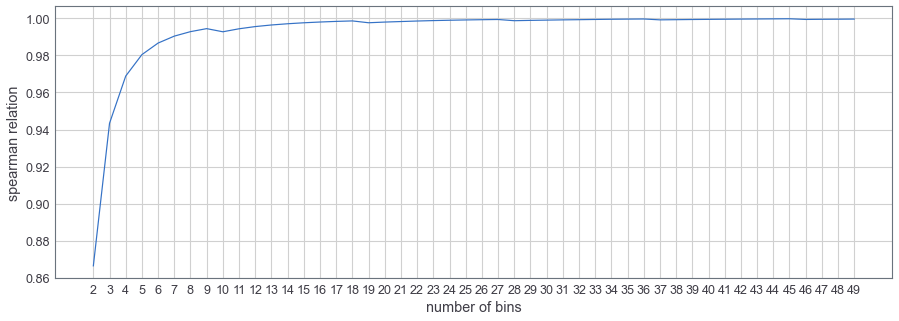

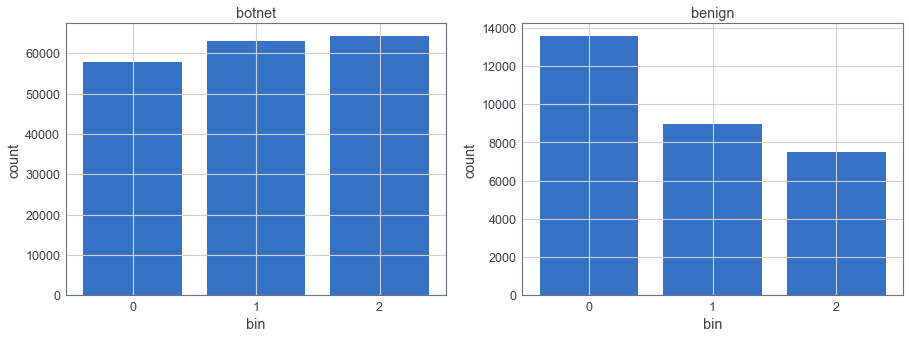

CTU-13 scenarios 10


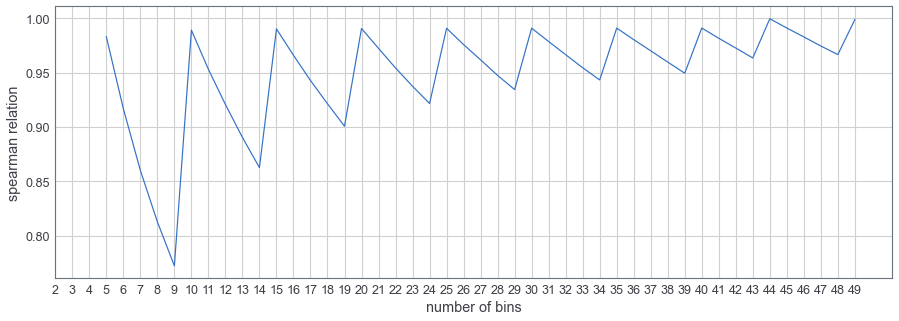

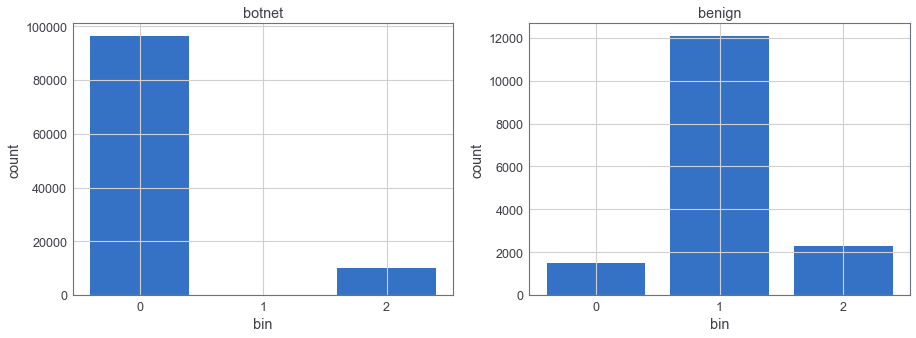

CTU-13 scenarios 11


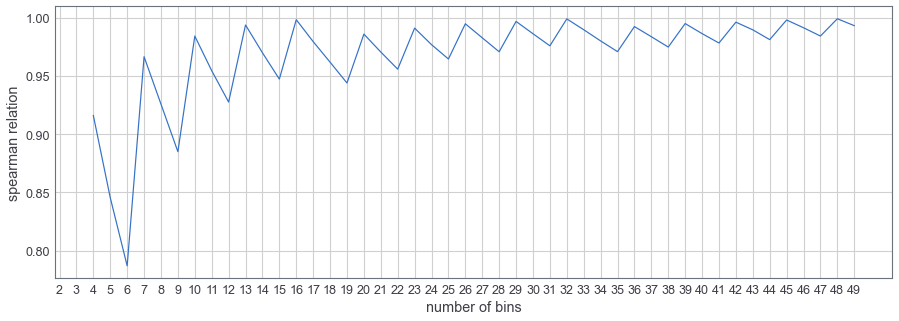

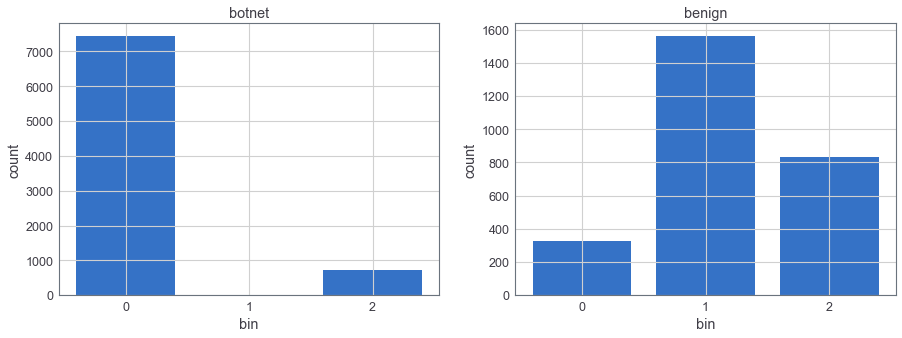

CTU-13 scenarios 12


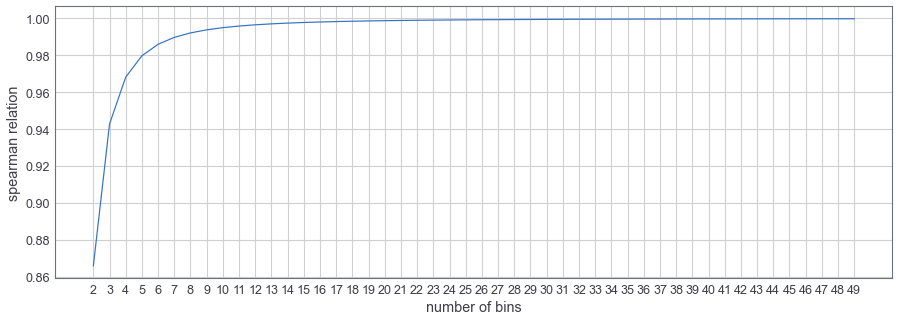

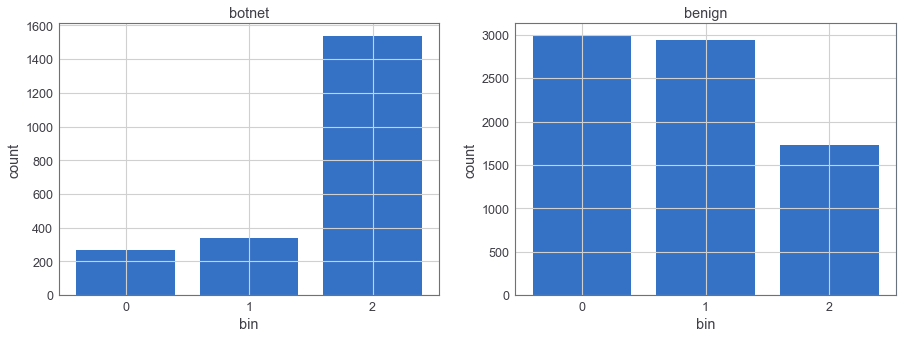

In [5]:
# load data
raw_source9 = pd.read_csv('./dataset/dataset_9/capture20110817.binetflow')
raw_source10 = pd.read_csv('./dataset/dataset_10/capture20110818.binetflow')
raw_source11 = pd.read_csv('./dataset/dataset_11/capture20110818-2.binetflow')
raw_source12 = pd.read_csv('./dataset/dataset_12/capture20110819.binetflow')

# preprocessing
print("CTU-13 scenarios 9")
source9 = discretization(raw_source9, quantile=3, plot=True, sel=9)
print("CTU-13 scenarios 10")
source10 = discretization(raw_source10, quantile=10, plot=True, sel=10)
print("CTU-13 scenarios 11")
source11 = discretization(raw_source11, quantile=7, plot=True, sel=11)
print("CTU-13 scenarios 12")
source12 = discretization(raw_source12, quantile=3, plot=True, sel=12)

#### Process Data

In [7]:
# For dataset 9
benign_source9 = source9[source9['Botnet'] != 1]
botnet_source9 = source9[source9['Botnet'] == 1]
new_benign_source9 = aggregation(benign_source9)
new_botnet_source9 = aggregation(botnet_source9)
new_all_source9 = aggregation(source9)

# For dataset 10
benign_source10 = source10[source10['Botnet'] != 1]
botnet_source10 = source10[source10['Botnet'] == 1]
new_benign_source10 = aggregation(benign_source10)
new_botnet_source10 = aggregation(botnet_source10)
new_all_source10 = aggregation(source10)

#For dataset 11
benign_source11 = source11[source11['Botnet'] != 1]
botnet_source11 = source11[source11['Botnet'] == 1]
new_benign_source11 = aggregation(benign_source11)
new_botnet_source11 = aggregation(botnet_source11)
new_all_source11 = aggregation(source11)

# For dataset12
benign_source12 = source12[source12['Botnet'] != 1]
botnet_source12 = source12[source12['Botnet'] == 1]
new_benign_source12 = aggregation(benign_source12)
new_botnet_source12 = aggregation(botnet_source12)
new_all_source12 = aggregation(source12)

#### Count for each gram

In [11]:
# Count 3-gram for benign data
count_gram(new_benign_source9)
count_gram(new_benign_source10)
count_gram(new_benign_source11)
count_gram(new_benign_source12)

In [12]:
# Count 3-gram for all data
count_gram(new_all_source9)
count_gram(new_all_source10)
count_gram(new_all_source11)
count_gram(new_all_source12)

#### Get results for benign features

In [15]:
benign_feature9 = count_feature(new_benign_source9)
benign_feature10 = count_feature(new_benign_source10)
benign_feature11 = count_feature(new_benign_source11)
benign_feature12 = count_feature(new_benign_source12)

#### Predict for all source based on benign features

In [21]:
pred_botnet(new_all_source9,benign_feature9)
pred_botnet(new_all_source10,benign_feature10)
pred_botnet(new_all_source11,benign_feature11)
pred_botnet(new_all_source12,benign_feature12)

array([0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0])

#### Print confusion matrix for predicted results

new_source9


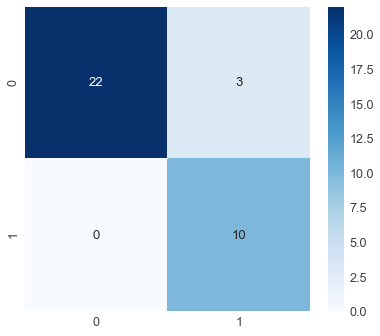

In [22]:
print("new_source9")
result9 = confusion_matrix(new_all_source9.Label.values, new_all_source9.Pred.values)
sns.heatmap(result9, annot=True, cmap='Blues')
plt.show()

new_source10


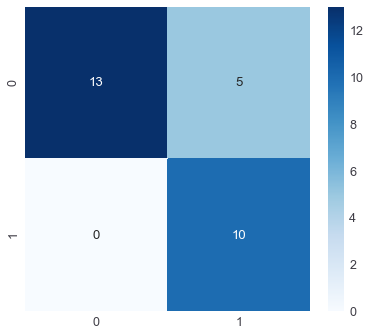

In [23]:
print("new_source10")
result10 = confusion_matrix(new_all_source10.Label.values, new_all_source10.Pred.values)
sns.heatmap(result10, annot=True, cmap='Blues')
plt.show()

new_source11


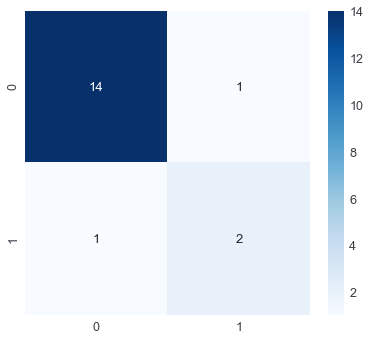

In [24]:
print("new_source11")
result11 = confusion_matrix(new_all_source11.Label.values, new_all_source11.Pred.values)
sns.heatmap(result11, annot=True, cmap='Blues')
plt.show()

new_source12


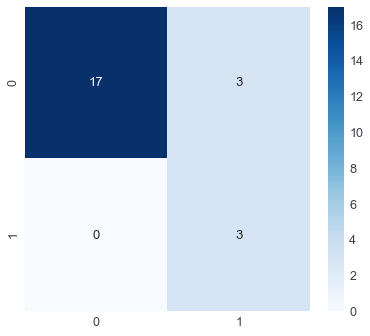

In [25]:
print("new_source12")
result12 = confusion_matrix(new_all_source12.Label.values, new_all_source12.Pred.values)
sns.heatmap(result12, annot=True, cmap='Blues')
plt.show()

### 7b. Analysis and answers to the questions.

The fingerprinting task relies on the fact that some 3-grams do not occur for benign hosts and do occur for infected hosts the rather than the distances between a selected host and other hosts in the profiling task to distinguish the hosts. 

First, we discretize all four datasets and then extract the benign ones. 

Second, we do the 3-gram counting to the benign data set and all data set. This step could gather how many times one feature appearing in the data set. The former serves as the train set to find and store the occurred 3-gram features. The latter contains both infected and non-infected data that is used to be compared with the predicted result. In this step, we modify the method to define the occurred and un-occurred features with a probability of 1/27. In other words, if a 3-gram feature appears more than 1/27 of the length of the feature list, we identify it as occurred.

Third, the occurred featured found in step2 is applied in the 3-gram discretized all-data set to predict whether the host with different features is infected or not. The predicted result is appended in the column 'Pred' of the data frame. 

Last, by comparing the 'Label' and 'Pred' columns, we get the four confusion matrixes above. 

If we compare the confusion matrixes to those of the botnet profiling task, we see that the results of fingerprinting are slightly better. It is because in step2 we set the rule to identify the occurred feature with a probability threshold.